In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gpflow
from gpflow.ci_utils import reduce_in_tests
from gpflow.kernels import Matern12, Matern32, Matern52, Linear
from gpflow.utilities import print_summary

from sklearn.preprocessing import StandardScaler

from mom_trans.changepoint_detection import fit_matern_kernel, fit_changepoint_kernel
from mom_trans.data_prep import calc_returns
from mom_trans.changepoint_detection import ChangePointsWithBounds

plt.style.use("ggplot")
%matplotlib inline


/Users/charliechen/miniconda3/envs/gp_env/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/charliechen/miniconda3/envs/gp_env/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [2]:

# np.random.seed(27)
# f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
# plotkernelsample(gpflow.kernels.Matern12(), axes[0, 0])
# plotkernelsample(gpflow.kernels.Matern32(), axes[0, 1])
# plotkernelsample(gpflow.kernels.Matern52(), axes[0, 2])
# plotkernelsample(gpflow.kernels.RBF(), axes[0, 3])
# plotkernelsample(gpflow.kernels.Constant(), axes[1, 0])
# plotkernelsample(gpflow.kernels.Linear(), axes[1, 1])
# plotkernelsample(gpflow.kernels.Cosine(), axes[1, 2])
# plotkernelsample(
#     gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential()), axes[1, 3]
# )
# _ = axes[0, 0].set_ylim(-3, 3)

/Users/charliechen/miniconda3/envs/gp_env/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


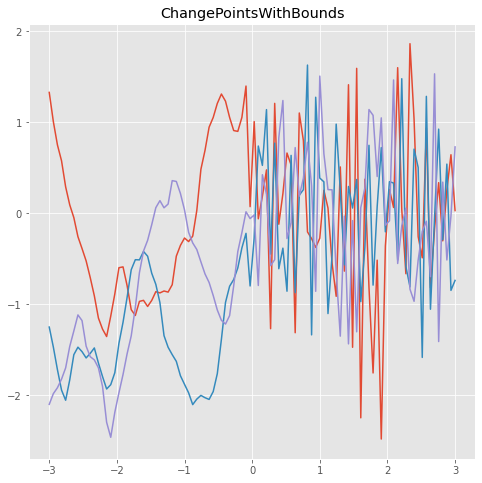

In [3]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    n_grid = reduce_in_tests(100)
    xx = np.linspace(xmin, xmax, n_grid)[:, None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(n_grid), K, 3).T)
    ax.set_title(k.__class__.__name__)

def get_kernel(kernel_class,
               k1_variance, 
               k1_lengthscale, 
               k2_variance, 
               k2_lengthscale, 
               kC_steepness, 
               kC_changepoint_location,
               dummy = False,
               **kwargs):
    kernel1 = kernel_class(variance=k1_variance, lengthscales=k1_lengthscale)
    kernel2 = kernel_class(variance=k2_variance, lengthscales=k2_lengthscale)

    kernel=ChangePointsWithBounds(
        [
            kernel1,
            kernel2,
        ],
        location=0 if dummy else kC_changepoint_location,
        interval=(-1000, 1000),
        steepness=kC_steepness,
    )
    
    return kernel

path = 'data/currency_cpd_2020-01-01_2023-01-01_63lbw_Matern32/EUR_param.csv'
cp_path = 'data/currency_cpd_2020-01-01_2023-01-01_63lbw_Matern32/EUR.csv'
lbw = 63

df = pd.merge(pd.read_csv(path), pd.read_csv(cp_path), on='date')
sample = dict(df.iloc[32])
sample['kernel_class'] = Matern32
sample_kernel = get_kernel(dummy=True,**sample)

f, axes = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True)

plotkernelsample(sample_kernel, axes, -3, 3)
f.savefig("kernel_sample.png")

In [4]:

data_path = 'data/currency/EUR.csv'
time_series_data = pd.read_csv(data_path, parse_dates=[0])
time_series_data['daily_returns'] = calc_returns(time_series_data['Settle'])

# data_df = data_df.set_index('Trade Date')
len(time_series_data)

16876

In [5]:

# from datetime import datetime, timedelta
# date_string = "1990-01-02"
# date_format = "%Y-%m-%d"
# base_date = datetime.strptime(date_string, date_format) - timedelta(lbw)

In [6]:
df.sort_values('cp_score',ascending=False).head()

,date,k1_variance,k1_lengthscale,k2_variance,k2_lengthscale,kC_likelihood_variance,kC_changepoint_location,kC_steepness,t,cp_location,cp_location_norm,cp_score
68,2020-04-07,1.150496e-06,0.415561,1.859693,0.604888,0.164031,102.246184,2.025773,131,102.246184,0.456410,1.0
66,2020-04-03,2.729718e-06,0.506087,1.982580,0.619323,0.173567,102.170372,1.548347,129,102.170372,0.425867,1.0
63,2020-03-31,1.061567e-06,0.363693,2.126333,0.597266,0.209522,102.290254,2.072215,126,102.290254,0.376345,1.0
67,2020-04-06,5.982138e-07,0.468431,1.889410,0.595862,0.178174,102.164246,1.752515,130,102.164246,0.441837,1.0
69,2020-04-08,5.640614e-06,0.953641,1.777875,0.589727,0.168863,102.219237,2.325990,132,102.219237,0.472711,1.0


In [7]:
sample = df.sort_values('cp_score',ascending=False).iloc[28] # 28
start,end = sample.t - lbw, sample.t + 1

time_series_data["X"] = time_series_data.index.astype(float)
time_series_data = time_series_data.rename(columns={"daily_returns": "Y"})
ts_data_window = time_series_data[start: end]
len(ts_data_window)
# base_t = int(sample.t) - lbw
# start_date = base_date + timedelta(base_t)
# end_date = base_date + timedelta(int(sample.t) + 20)

# ts_data_window = data_df.loc[start_date: end_date]
# ts_data_window["X"] = ts_data_window.index.astype(float)

64

In [8]:
sample

date                       2020-04-28
k1_variance                  0.122613
k1_lengthscale               0.718942
k2_variance                  1.454155
k2_lengthscale               0.499362
kC_likelihood_variance       0.000007
kC_changepoint_location    102.069532
kC_steepness                 9.438377
t                                 144
cp_location                102.069532
cp_location_norm             0.665563
cp_score                     0.999999
Name: 81, dtype: object

In [9]:

# sample_kernel = get_kernel(Matern32, **sample)
# X = np.arange(len(time_window)).reshape(-1,1).astype(np.double)
# y = time_window.values * 10

# y = np.arange(len(y)).reshape(-1,1).astype(np.double)
def get_model(ts_data_window, 
              k1_variance, k2_variance, k1_lengthscale, k2_lengthscale, 
              kC_changepoint_location, kC_steepness, kC_likelihood_variance,
              **kwargs):

    
    kernel1 = Matern32(variance=k1_variance, lengthscales=k1_lengthscale)
    kernel2 = Matern32(variance=k2_variance, lengthscales=k2_lengthscale)
    
    Y_data = ts_data_window[["Y"]].values
    ts_data_window[["Y"]] = StandardScaler().fit(Y_data).transform(Y_data)
    Y = ts_data_window.loc[:, ["Y"]].to_numpy()
    # print(ts_data_window.loc[:, ["X"]].to_numpy())

    m = gpflow.models.GPR(
        data=(
            ts_data_window.loc[:, ["X"]].to_numpy(),
            Y,
        ),
        kernel=ChangePointsWithBounds(
            [
                kernel1,
                kernel2,
            ],
            location=kC_changepoint_location,
            interval=(ts_data_window["X"].iloc[0], ts_data_window["X"].iloc[-1]),
            steepness=kC_steepness,
        ),
    )
    print(ts_data_window["X"].iloc[0], ts_data_window["X"].iloc[-1], kC_changepoint_location)
    m.likelihood.variance.assign(kC_likelihood_variance)
    return m


m = get_model(ts_data_window, **sample)
m.log_marginal_likelihood()

81.0 144.0 102.06953224837432


/Users/charliechen/miniconda3/envs/gp_env/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


<tf.Tensor: shape=(), dtype=float64, numpy=-144.04342904831287>

In [10]:
print_summary(m)


╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value       │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.12261     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.71894     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ 

In [11]:
nlml, kM_params = (fit_matern_kernel(ts_data_window))
def get_naive_kernel(ts_data_window, variance, lengthscale, likelihood_variance):
    current_kernel = Matern32(variance=variance, lengthscales=lengthscale)

    m = gpflow.models.GPR(
        data=(
            ts_data_window.loc[:, ["X"]].to_numpy(),
            ts_data_window.loc[:, ["Y"]].to_numpy(),
        ),
        kernel=current_kernel,
        noise_variance=likelihood_variance,
    )
    return m
kM_m = get_naive_kernel(ts_data_window, kM_params['kM_variance'], kM_params['kM_lengthscales'], kM_params['kM_likelihood_variance'])

2022-12-20 14:07:32.193490: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


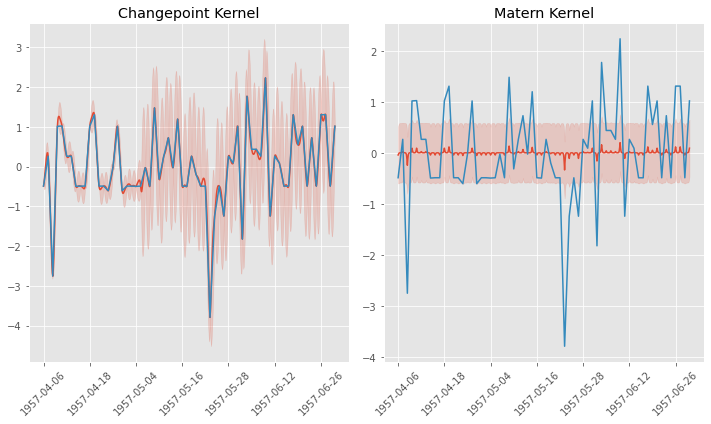

In [12]:
def plot_graph(m, ax, title):
    X = ts_data_window.loc[:, ["X"]].to_numpy()
    Y = ts_data_window.loc[:, ["Y"]].to_numpy()

    k = 10
    xx = np.linspace(X[0], X[-1], len(X) * k - k + 1, endpoint=True).reshape(
        len(X) * k - k + 1, 1
    )  # test points must be of shape (N, D)

    mean, var = m.predict_f(xx)


    # mean = (StandardScaler().fit(mean).transform(mean))
    ax.plot(xx, mean)
    ax.plot(X, Y)
    ax.fill_between(
        xx[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )
    gap = 10

    dates = list(ts_data_window['Trade Date'].transform(lambda x: str(x).split()[0]).values)
    selected_dates = [dates[i] for i in range(0, len(dates), gap)]
    selected_X = [X.squeeze()[i] for i in range(0, len(X), gap)]

    ax.set_xticks(selected_X, selected_dates, rotation=45)
    ax.set_title(title)
fig, axes = plt.subplots(1,2, figsize=(10,6))
plot_graph(m, axes[0], "Changepoint Kernel")
plot_graph(kM_m, axes[1], "Matern Kernel")

plt.tight_layout()
plt.show()


In [13]:
fig.savefig("predictive_distribution.png")

In [14]:

# date                       2022-03-16
# k1_variance                  0.359484
# k1_lengthscale               0.073333
# k2_variance                  1.438239
# k2_lengthscale                0.07078
# kC_likelihood_variance       0.000005
# kC_changepoint_location    592.696446
# kC_steepness               291.010264
# t                                 630
# cp_location                592.696446
# cp_location_norm              0.59212
# cp_score                     0.998333

In [15]:
variance, lengthscale = 1, 1
tmp_kernel = Matern32(variance=variance, lengthscales=lengthscale) * Linear(variance)
tmp_kernel.kernels[0]

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


# Garbage

In [16]:
print_summary(m)


╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value       │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.12261     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.71894     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ 

In [17]:
normalized_ts_data_window = ts_data_window.copy()
normalized_ts_data_window[["Y"]] = StandardScaler().fit(normalized_ts_data_window[["Y"]]).transform(normalized_ts_data_window[["Y"]])


nlml, params = (fit_matern_kernel(normalized_ts_data_window))
print(nlml, params)
print()
print(fit_changepoint_kernel(ts_data_window))

(changepoint_location, kC_nlml, kC_params) = fit_changepoint_kernel(
    normalized_ts_data_window,
    k1_variance=params['kM_variance'],
    k1_lengthscale=params['kM_lengthscales'],
    k2_variance=params['kM_variance'],
    k2_lengthscale=params['kM_lengthscales'],
    kC_likelihood_variance=params['kM_likelihood_variance'],
    # kC_changepoint_location=kC_changepoint_location,
    # kC_steepness=kC_steepness,
    kernel_choice='Matern32'
)
changepoint_location, kC_nlml, kC_params

90.8120662715616 {'kM_variance': array(0.08872818), 'kM_lengthscales': array(0.10456162), 'kM_likelihood_variance': array(0.91126369)}

(116.31365404371991, 87.8200366038626, {'k1_variance': 1.563848952896944e-18, 'k1_lengthscale': 5.803277242367804e-10, 'k2_variance': 0.8628069281575472, 'k2_lengthscale': 1.0466993786313279e-11, 'kC_likelihood_variance': 0.6225288870246275, 'kC_changepoint_location': 116.31365404371991, 'kC_steepness': array(25.40651594)})


(116.30686241933702,
 87.82003723794631,
 {'k1_variance': 1.808868697419571e-05,
  'k1_lengthscale': 0.1045506374250319,
  'k2_variance': 0.862775015616759,
  'k2_lengthscale': 0.10455980698538699,
  'kC_likelihood_variance': 0.6225195984345047,
  'kC_changepoint_location': 116.30686241933702,
  'kC_steepness': array(24.60403538)})

In [18]:
def get_kC_model(ts_data_window, 
                 k1_variance,
                 k1_lengthscale,
                 k2_variance,
                 k2_lengthscale,
                 kC_changepoint_location,
                 kC_steepness,
                 kernel_choice,
                 kC_likelihood_variance,
                 k1_linear_variance=None,
                k2_linear_variance=None
                ):
    kernel1 = None
    kernel2 = None

    if kernel_choice == "Matern12":
        kernel1 = Matern12(variance=k1_variance, lengthscales=k1_lengthscale)
        kernel2 = Matern12(variance=k2_variance, lengthscales=k2_lengthscale)
    elif kernel_choice == "Matern32":
        kernel1 = Matern32(variance=k1_variance, lengthscales=k1_lengthscale)
        kernel2 = Matern32(variance=k2_variance, lengthscales=k2_lengthscale)
    elif kernel_choice == "Matern52":
        kernel1 = Matern52(variance=k1_variance, lengthscales=k1_lengthscale)
        kernel2 = Matern52(variance=k2_variance, lengthscales=k2_lengthscale)
    elif "Linear" in kernel_choice:
        matern = eval(kernel_choice.split('_')[-1])
        kernel1 = matern(variance=k1_variance, lengthscales=k1_lengthscale) + Linear(k1_linear_variance)
        kernel2 = matern(variance=k2_variance, lengthscales=k2_lengthscale) + Linear(k2_linear_variance)
    else:
        raise NotImplementedError
    
    Y_data = ts_data_window[["Y"]].values
    ts_data_window[["Y"]] = StandardScaler().fit(Y_data).transform(Y_data)
        
    m = gpflow.models.GPR(
        data=(
            ts_data_window.loc[:, ["X"]].to_numpy(),
            ts_data_window.loc[:, ["Y"]].to_numpy(),
        ),
        kernel=ChangePointsWithBounds(
            [
                kernel1,
                kernel2,
            ],
            location=kC_changepoint_location,
            interval=(time_series_data["X"].iloc[0], time_series_data["X"].iloc[-1]),
            steepness=kC_steepness,
        ),
    )
    m.likelihood.variance.assign(kC_likelihood_variance)
    return m
m = get_kC_model(ts_data_window, kernel_choice="Matern32", **kC_params)
m.log_marginal_likelihood()

/Users/charliechen/miniconda3/envs/gp_env/lib/python3.8/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


<tf.Tensor: shape=(), dtype=float64, numpy=-87.82003723794631>

In [19]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=200)
).fun
changepoint_location = m.kernel.locations[0].numpy()
changepoint_location, opt_logs, m.log_marginal_likelihood()

(116.30734560669252,
 87.8200372302675,
 <tf.Tensor: shape=(), dtype=float64, numpy=-87.8200372302675>)